In [1]:
#=============================================================================
# Boston Housing Price Prediction using Stacking Regressor + Optuna
#=============================================================================

# Importing Libraries
import numpy as np
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.preprocessing import StandardScaler
import pickle
import warnings
from sklearn.ensemble import StackingRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [37]:
# Load Dataset
df = pd.read_csv(r"C:\Users\HP\OneDrive\Desktop\HousingData.csv")
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,House_price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,NaN,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [3]:
df.isnull().sum()

CRIM           20
ZN             20
INDUS          20
CHAS           20
NOX             0
RM              0
AGE            20
DIS             0
RAD             0
TAX             0
PTRATIO         0
B               0
LSTAT          20
House_price     0
dtype: int64

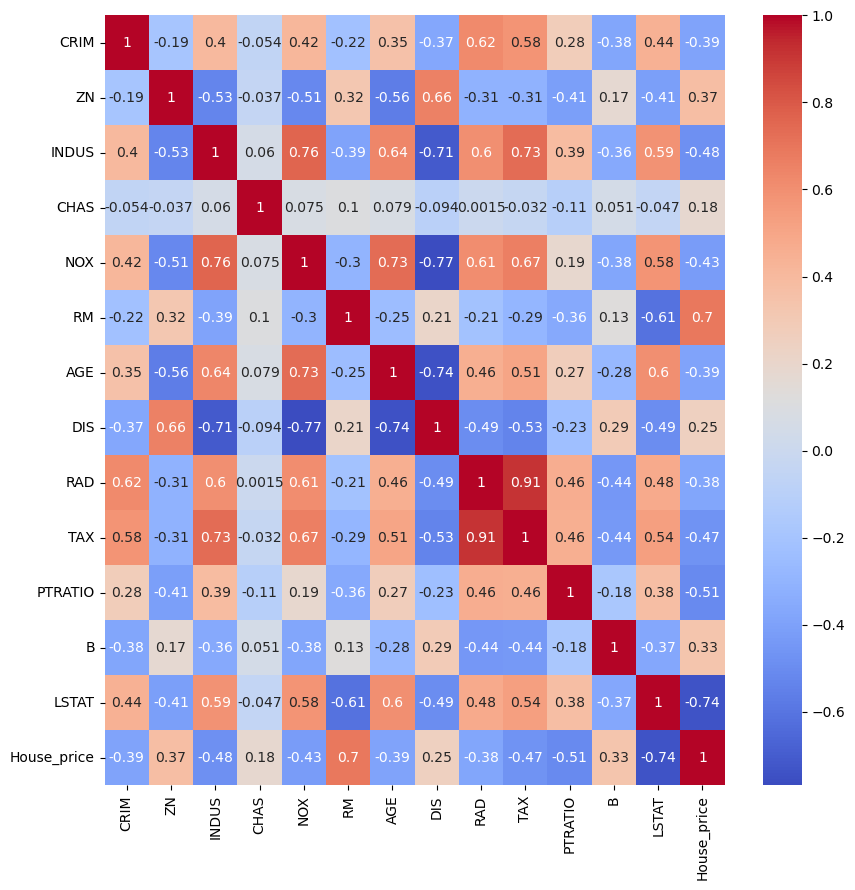

In [40]:
plt.figure(figsize=(10,10))
corr = df.corr()
sns.heatmap(corr,annot=True,cmap="coolwarm")
plt.show()

In [4]:
# Filling Missing Values
df = df.fillna(df.median())

In [5]:
# Feature and Target selection
x = df.drop("House_price",axis=1)
y = df["House_price"]

In [6]:
# Split Training and Testing Data
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [7]:
# Feature Scaling
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [20]:
from sklearn.ensemble import RandomForestRegressor

def tune_rf(trial):
    params = {
        "n_estimators":trial.suggest_int("n_estimators",100,500),
        "max_depth":trial.suggest_int("max_depth",3,10),
        "min_samples_split":trial.suggest_int("min_samples_split",3,10),
        "min_samples_leaf":trial.suggest_int("min_samples_leaf",3,10),
        "oob_score":True,
        "random_state":42
    }
    model = RandomForestRegressor(**params)
    score = cross_val_score(model,x_train,y_train,cv=5,scoring="r2").mean()
    return score
    

In [27]:
sampler = optuna.samplers.TPESampler(seed=42)
study_rf = optuna.create_study(direction = "maximize",sampler=sampler)
study_rf.optimize(tune_rf,n_trials=30)
best_rf_params = study_rf.best_params

[I 2025-11-03 09:19:52,540] A new study created in memory with name: no-name-cc38014e-2123-4ff0-a291-c5b1dba2161d
[I 2025-11-03 09:19:55,015] Trial 0 finished with value: 0.7864891259208269 and parameters: {'n_estimators': 250, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.7864891259208269.
[I 2025-11-03 09:19:56,445] Trial 1 finished with value: 0.7774345804677103 and parameters: {'n_estimators': 162, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.7864891259208269.
[I 2025-11-03 09:19:59,454] Trial 2 finished with value: 0.7813256879403554 and parameters: {'n_estimators': 341, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.7864891259208269.
[I 2025-11-03 09:20:03,216] Trial 3 finished with value: 0.7813038400974703 and parameters: {'n_estimators': 433, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 0 with value: 

In [28]:
#=======================================================================================
# Optuna Hyperparameter Tuning Functions
#=======================================================================================


def tune_xgb(trial):
    params = {
        "n_estimators":trial.suggest_int("n_estimators",100,500),
        "max_depth":trial.suggest_int("max_depth",3,10),
        "learning_rate":trial.suggest_float("learning_rate",0.01,0.3),
        "subsample":trial.suggest_float("subsample",0.6,1.0),
        "colsample_bytree":trial.suggest_float("colsample_bytree",0.6,1.0),
        "gamma":trial.suggest_float("gamma",0.6,5.0),
        "reg_lambda":trial.suggest_float("reg_lambda",0.1,10),
        "reg_alpha":trial.suggest_float("reg_alpha",0.1,10),
        "random_state":42
    }
    model = XGBRegressor(**params)
    score = cross_val_score(model,x_train,y_train,cv=5,scoring="r2").mean()
    return score

In [9]:
def tune_cat(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 500),
        "depth": trial.suggest_int("depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "random_seed": 42,
        "verbose": 0
    }
    model = CatBoostRegressor(**params)
    score = cross_val_score(model, x_train, y_train, cv=5, scoring="r2").mean()
    return score

In [10]:
def tune_gb(trial):
    params = {
        "n_estimators":trial.suggest_int("n_estimators",100,500),
        "max_depth":trial.suggest_int("max_depth",3,10),
        "learning_rate":trial.suggest_float("learning_rate",0.01,0.3),
        "subsample":trial.suggest_float("subsample",0.6,1.0),
        "random_state":42
    }
    model = GradientBoostingRegressor(**params)
    score = cross_val_score(model,x_train,y_train,cv=5,scoring="r2").mean()
    return score



In [29]:
#=================================================================================
# Run Optuna Optimization for each model
#=================================================================================

study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(tune_xgb,n_trials=30)
best_xgb_params = study_xgb.best_params

[I 2025-11-03 10:01:12,953] A new study created in memory with name: no-name-46c208cf-fb62-4966-974e-1440b57ba80b
[I 2025-11-03 10:01:13,390] Trial 0 finished with value: 0.8248550152859637 and parameters: {'n_estimators': 151, 'max_depth': 6, 'learning_rate': 0.03323624770722578, 'subsample': 0.6280620315688813, 'colsample_bytree': 0.8445234021034932, 'gamma': 0.8921550947273147, 'reg_lambda': 3.0499759261899833, 'reg_alpha': 6.143190878011338}. Best is trial 0 with value: 0.8248550152859637.
[I 2025-11-03 10:01:13,753] Trial 1 finished with value: 0.8406761083350505 and parameters: {'n_estimators': 366, 'max_depth': 3, 'learning_rate': 0.29587152866196226, 'subsample': 0.8240425793739395, 'colsample_bytree': 0.7242319839940428, 'gamma': 1.8815966606221886, 'reg_lambda': 0.717133600719674, 'reg_alpha': 5.7233571717517675}. Best is trial 1 with value: 0.8406761083350505.
[I 2025-11-03 10:01:13,999] Trial 2 finished with value: 0.8242332737875504 and parameters: {'n_estimators': 161, 'm

In [12]:
print("🔹 Tuning CatBoost...")
study_cat = optuna.create_study(direction="maximize")
study_cat.optimize(tune_cat, n_trials=30)
best_cat_params = study_cat.best_params


[I 2025-11-03 08:52:32,773] A new study created in memory with name: no-name-110ccda1-fdbc-4064-a779-0d691bc7e179


🔹 Tuning CatBoost...


[I 2025-11-03 08:52:34,350] Trial 0 finished with value: 0.7350662428033671 and parameters: {'iterations': 124, 'depth': 6, 'learning_rate': 0.014714413628098139, 'l2_leaf_reg': 1.3822896550217865}. Best is trial 0 with value: 0.7350662428033671.
[I 2025-11-03 08:52:40,572] Trial 1 finished with value: 0.8384581704409062 and parameters: {'iterations': 272, 'depth': 8, 'learning_rate': 0.2695791403513242, 'l2_leaf_reg': 2.147003046570967}. Best is trial 1 with value: 0.8384581704409062.
[I 2025-11-03 08:52:41,688] Trial 2 finished with value: 0.8401907351767235 and parameters: {'iterations': 111, 'depth': 6, 'learning_rate': 0.2797422105013424, 'l2_leaf_reg': 8.21922722778882}. Best is trial 2 with value: 0.8401907351767235.
[I 2025-11-03 08:52:44,947] Trial 3 finished with value: 0.8422416779692611 and parameters: {'iterations': 395, 'depth': 6, 'learning_rate': 0.268041377491831, 'l2_leaf_reg': 4.6755921203397355}. Best is trial 3 with value: 0.8422416779692611.
[I 2025-11-03 08:52:45

In [13]:
print("🔹 Tuning Gradient Boosting...")
study_gb = optuna.create_study(direction="maximize")
study_gb.optimize(tune_gb, n_trials=30)
best_gb_params = study_gb.best_params


[I 2025-11-03 08:55:14,186] A new study created in memory with name: no-name-b5a714b5-f227-4783-9cee-77aac55a2892


🔹 Tuning Gradient Boosting...


[I 2025-11-03 08:55:22,920] Trial 0 finished with value: 0.8385945830645489 and parameters: {'n_estimators': 388, 'max_depth': 6, 'learning_rate': 0.10127319288223476, 'subsample': 0.6113928927932689}. Best is trial 0 with value: 0.8385945830645489.
[I 2025-11-03 08:55:25,334] Trial 1 finished with value: 0.8241150804100071 and parameters: {'n_estimators': 122, 'max_depth': 3, 'learning_rate': 0.10541793941756036, 'subsample': 0.9530233067578345}. Best is trial 0 with value: 0.8385945830645489.
[I 2025-11-03 08:55:32,555] Trial 2 finished with value: 0.8246036439460129 and parameters: {'n_estimators': 276, 'max_depth': 6, 'learning_rate': 0.14704861606877476, 'subsample': 0.7796633151029538}. Best is trial 0 with value: 0.8385945830645489.
[I 2025-11-03 08:55:39,691] Trial 3 finished with value: 0.8389545844848045 and parameters: {'n_estimators': 276, 'max_depth': 6, 'learning_rate': 0.226323631030583, 'subsample': 0.784306311075199}. Best is trial 3 with value: 0.8389545844848045.
[I 

In [30]:
#================================================================================
# Build Best Models
#================================================================================

best_xgb = XGBRegressor(**best_xgb_params)
best_cat = CatBoostRegressor(**best_cat_params)
best_gd = GradientBoostingRegressor(**best_gb_params)
best_rf = RandomForestRegressor(**best_rf_params)

In [24]:
# Stacking Regressor
base_models = [
    ("xgb",best_xgb),
    ("cat",best_cat),
    ("gd",best_gd),
    ("rf",best_rf)
]
meta_model = LinearRegression()
stack = StackingRegressor(estimators=base_models,final_estimator=meta_model,cv=KFold(n_splits=10,shuffle=True,random_state=42))
stack.fit(x_train_scaled,y_train)

0:	learn: 8.9966777	total: 1.46ms	remaining: 596ms
1:	learn: 8.6637633	total: 2.9ms	remaining: 590ms
2:	learn: 8.3474366	total: 3.97ms	remaining: 538ms
3:	learn: 8.0871315	total: 5.13ms	remaining: 519ms
4:	learn: 7.7966207	total: 6.27ms	remaining: 507ms
5:	learn: 7.5450404	total: 7.6ms	remaining: 511ms
6:	learn: 7.2902879	total: 8.75ms	remaining: 503ms
7:	learn: 7.0754053	total: 9.93ms	remaining: 498ms
8:	learn: 6.8574248	total: 11.1ms	remaining: 493ms
9:	learn: 6.6778468	total: 12.6ms	remaining: 501ms
10:	learn: 6.4710517	total: 14ms	remaining: 508ms
11:	learn: 6.2528012	total: 15.9ms	remaining: 526ms
12:	learn: 6.0749987	total: 17ms	remaining: 516ms
13:	learn: 5.9241616	total: 18ms	remaining: 508ms
14:	learn: 5.7776570	total: 19ms	remaining: 499ms
15:	learn: 5.6544787	total: 20.3ms	remaining: 498ms
16:	learn: 5.5210352	total: 21.7ms	remaining: 501ms
17:	learn: 5.4031971	total: 22.9ms	remaining: 497ms
18:	learn: 5.2817787	total: 24ms	remaining: 492ms
19:	learn: 5.1913408	total: 25.2ms

StackingRegressor(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                  estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8775439018969781,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None,
                                            gam...
                                            num_parallel_tree=None, ...)),
                              ('cat',
                               <catboost.core.CatBoostRegressor object at 0x0000022722305B50>),
                              ('gd',
                               GradientBoostingRegressor(learning_rate=0.2992160347843062,
                                                         max_depth=7,
                                                         n_estimators=370,
                                                         subsample=0.681687264219631)),
                              ('rf',
                               RandomForestRegressor(max_depth=8,
                                                     min_samples_leaf=3,
                                                     min_samples_split=7,
                                                     n_estimators=324))],
                  final_estimator=LinearRegression())

In [31]:
# ============================================================
# 📈 Model Evaluation
# ============================================================
y_pred = stack.predict(x_test_scaled)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("\n================= Final Model Performance =================")
print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root MSE: {rmse:.4f}")



================= Final Model Performance =================
R² Score: 0.9093
Mean Squared Error: 6.6526
Root MSE: 2.5793


In [32]:
# Cross-validation score
cv_score = cross_val_score(stack, x_train_scaled, y_train, cv=10, scoring="r2").mean()
print(f"Cross-validation R²: {cv_score:.4f}")


0:	learn: 9.1057081	total: 1.2ms	remaining: 488ms
1:	learn: 8.7801345	total: 2.33ms	remaining: 474ms
2:	learn: 8.4636993	total: 3.23ms	remaining: 437ms
3:	learn: 8.1812411	total: 4.06ms	remaining: 411ms
4:	learn: 7.9141766	total: 4.94ms	remaining: 399ms
5:	learn: 7.6677062	total: 5.85ms	remaining: 393ms
6:	learn: 7.4296748	total: 6.79ms	remaining: 390ms
7:	learn: 7.1932180	total: 7.73ms	remaining: 387ms
8:	learn: 6.9741777	total: 8.64ms	remaining: 384ms
9:	learn: 6.8007389	total: 9.58ms	remaining: 382ms
10:	learn: 6.5909020	total: 10.6ms	remaining: 385ms
11:	learn: 6.4100511	total: 11.8ms	remaining: 389ms
12:	learn: 6.2421174	total: 12.8ms	remaining: 389ms
13:	learn: 6.0838475	total: 13.7ms	remaining: 388ms
14:	learn: 5.9080624	total: 14.7ms	remaining: 386ms
15:	learn: 5.7529653	total: 15.6ms	remaining: 384ms
16:	learn: 5.6300236	total: 16.6ms	remaining: 382ms
17:	learn: 5.5241064	total: 17.5ms	remaining: 380ms
18:	learn: 5.3710576	total: 18.4ms	remaining: 378ms
19:	learn: 5.2445517	to

In [36]:
house = "House_price.sav"
pickle.dump(stack,open(house,"wb"))